## We use the VAE from vae.py to try to gain similar performance as in my project.

We have made some changes now! Now, the categorical features are trained according to Crossentropy loss and the numerical features according to MSE-loss. Each categorical feature has an output layer with #nodes = #levels. Each of the logits in each of the nodes is then compared to the labels using crossentropyloss. 

Talk with supervisor about if this makes sense or not!

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import seaborn as sbs

# Configure the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using '{device}' device.")

# Set some seeds.
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Import the code I have written.
from Data import Data, CustomDataset, ToTensor
from vae import VAE, train

Using 'cuda' device.


In [160]:
# Load the data.
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)
#print(adult_data.info()) 

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# We reorder adult_data such that all the numerical features come first, then the categorical features. 
adult_data = adult_data[numerical_features + categorical_features + ["y"]]
#print(adult_data.info()) 

def find_levels(df, categorical_features):
    """Returns a list of levels of features of each of the categorical features."""
    lens_categorical_features = []
    for feat in categorical_features:
        unq = len(df[feat].value_counts().keys().unique())
        print(f"Feature '{feat}'' has {unq} unique levels")
        lens_categorical_features.append(unq)
    print(f"The sum of all levels is {sum(lens_categorical_features)}. This will be the number of cat-columns after one-hot encoding (non-full rank)")
    return(lens_categorical_features)

lens_categorical_features = find_levels(adult_data.loc[:,adult_data.columns != "y"], categorical_features)
print(lens_categorical_features)

# Make Adult Dataclass. 
Adult = Data(adult_data, categorical_features, numerical_features, valid = False, splits = [6/7, 1/7])

# Load the preprocessed data. 
X_train_prep, y_train = Adult.get_training_data_preprocessed()
X_test_prep, y_test = Adult.get_test_data_preprocessed()
#X_valid_prep, y_valid = Adult.get_validation_data_preprocessed()
#print(X_train_prep.shape)
#print(X_train_prep.info())

# Load the original data to have for later. 
X_train_og, _  = Adult.get_training_data()
X_test_og, _  = Adult.get_test_data()
#X_valid_og, _ = Adult.get_validation_data()

# Make training data for Pytorch. 
train_data = CustomDataset(X_train_prep, y_train, transform = ToTensor())

Feature 'workclass'' has 7 unique levels
Feature 'marital_status'' has 7 unique levels
Feature 'occupation'' has 14 unique levels
Feature 'relationship'' has 6 unique levels
Feature 'race'' has 5 unique levels
Feature 'sex'' has 2 unique levels
Feature 'native_country'' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)
[7, 7, 14, 6, 5, 2, 41]


In [161]:
# Set some hyperparameters.
batch_size = 16 
input_size = X_train_prep.shape[1]
latent_dim = 8

# Define the training data loader. 
train_data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

In [162]:
autoencoder = VAE(input_size, latent_dim, len(numerical_features), lens_categorical_features).to(device)
# We assume that the first group of features is numerical and the rest/second is categorical. 
autoencoder

VAE(
  (encoder): VariationalEncoder(
    (l1): Linear(in_features=88, out_features=15, bias=True)
    (l2): Linear(in_features=15, out_features=8, bias=True)
    (l3): Linear(in_features=15, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (l1): Linear(in_features=8, out_features=15, bias=True)
    (l2): Linear(in_features=15, out_features=6, bias=True)
    (cat_output_layers): ModuleList(
      (0): Linear(in_features=15, out_features=7, bias=True)
      (1): Linear(in_features=15, out_features=7, bias=True)
      (2): Linear(in_features=15, out_features=14, bias=True)
      (3): Linear(in_features=15, out_features=6, bias=True)
      (4): Linear(in_features=15, out_features=5, bias=True)
      (5): Linear(in_features=15, out_features=2, bias=True)
      (6): Linear(in_features=15, out_features=41, bias=True)
    )
    (relu): ReLU()
  )
)

In [163]:
autoencoder, train_losses = train(autoencoder, train_data_loader, epochs = 15, device = device)

Epoch [1/15], Step [500/2423], Loss: 97.8530
Epoch [1/15], Step [1000/2423], Loss: 70.3873
Epoch [1/15], Step [1500/2423], Loss: 74.5733
Epoch [1/15], Step [2000/2423], Loss: 77.7788
Epoch [2/15], Step [500/2423], Loss: 94.3822
Epoch [2/15], Step [1000/2423], Loss: 57.2605
Epoch [2/15], Step [1500/2423], Loss: 73.9644
Epoch [2/15], Step [2000/2423], Loss: 83.4057
Epoch [3/15], Step [500/2423], Loss: 72.0541
Epoch [3/15], Step [1000/2423], Loss: 68.4637
Epoch [3/15], Step [1500/2423], Loss: 71.4990
Epoch [3/15], Step [2000/2423], Loss: 66.3698
Epoch [4/15], Step [500/2423], Loss: 71.1390
Epoch [4/15], Step [1000/2423], Loss: 80.3145
Epoch [4/15], Step [1500/2423], Loss: 57.3363
Epoch [4/15], Step [2000/2423], Loss: 62.3160
Epoch [5/15], Step [500/2423], Loss: 85.0788
Epoch [5/15], Step [1000/2423], Loss: 107.1810
Epoch [5/15], Step [1500/2423], Loss: 74.1134
Epoch [5/15], Step [2000/2423], Loss: 70.6502
Epoch [6/15], Step [500/2423], Loss: 78.9201
Epoch [6/15], Step [1000/2423], Loss: 7

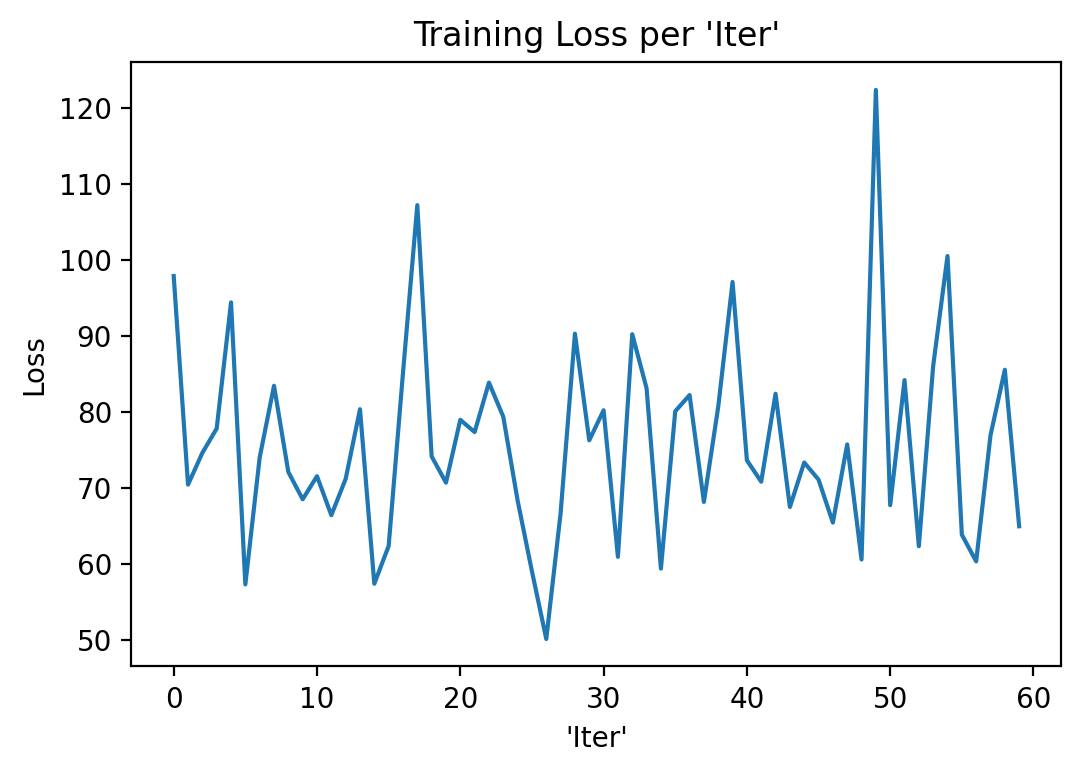

In [164]:
plt.plot(train_losses)
plt.title("Training Loss per 'Iter'")
plt.xlabel("'Iter'")
plt.ylabel("Loss")
plt.show()
# Does not really learn a lot it seems like! Seems very volatile!
# We have a look at synthesized samples from N(0,1) (decoded) despite this. 

In [165]:
# Synthesize some data.
def sample(batch_size, dim ):
    """Samples from the standard Gaussian."""
    return torch.randn((batch_size, dim))

with torch.no_grad():
    s = sample(100000, latent_dim).to(device)
    x_hat_num, x_hat_cats = autoencoder.decoder(s)
    x_hat_num_np = x_hat_num.cpu().numpy()
    
    # Start building the dataframe for the synthetic data.
    s_df = pd.DataFrame(x_hat_num_np, columns = X_train_prep.columns[:len(numerical_features)].tolist())
    
    print(s_df.head())
    
    # Unpack the synthetic categorical data.
    s = nn.Softmax(dim = 1)
    
    all_feature_names = list(Adult.encoder.get_feature_names(Adult.categorical_features))
    lens_cumsum = np.cumsum(lens_categorical_features)
    lens_cumsum = np.insert(lens_cumsum, 0, 0, axis = 0)
    level_names = []
    for i, v in enumerate(lens_cumsum[1:]):
        first_index = lens_cumsum[i]
        final_index = v
        values = all_feature_names[first_index:final_index]
        level_names.append(values)
    
    
    for i, val in enumerate(x_hat_cats):
        probs = s(val) # Use the softmax to go from logits to probabilities.
        probs = probs.cpu().numpy()
        
        # Find maximum probability in each row. 
        maxs = np.argmax(probs, axis = 1)
        #print(maxs)
        #print(len(maxs))
        #print(maxs.dtype)
        
        #print(f"{i} {level_names[i]}")
        
        #print(level_names[i])
        
        # Map the index of the maximum probabilities back to the class level label.
        l_name = list(map(lambda x: level_names[i][x], maxs))
        #print(len(l_name))
        #print(l_name)
        
        s_df[categorical_features[i]] = l_name
        
    
    # Decode and descale the synthetic data.
    #s_df_new = Adult.decode(s_df)
    s_df_new = Adult.descale(s_df)
    # Decoding is no longer necessary since we did it manually above.
    # The reason behind this was the "new and strange way" of returning values from the decoder.

        age    fnlwgt  education_num  capital_gain  capital_loss  \
0  0.977857 -0.178708      -1.105404     -0.038053     -0.216375   
1  0.503300  0.461078       0.012319     -0.006741     -0.193937   
2  0.245306 -0.515121       0.416310     -0.003111     -0.212546   
3 -0.520656 -0.529958       0.145841     -0.026960     -0.200574   
4  0.271758 -0.248052       0.375137     -0.002642     -0.206751   

   hours_per_week  
0       -0.892596  
1        0.087323  
2        0.123600  
3       -0.255490  
4        0.161647  


In [166]:
# Look at the synthesized data. 
s_df_new.describe()
# We should round some of these features.
s_df_new["age"] = np.round(s_df_new["age"])
s_df_new["education_num"] = np.round(s_df_new["education_num"])
s_df_new["hours_per_week"] = np.round(s_df_new["hours_per_week"])
s_df_new.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,40.258518,188132.359375,10.263230,1083.520264,47.811958,40.921082
std,8.704994,61433.445312,1.356758,1640.962769,205.025177,6.886411
min,12.000000,80465.148438,4.000000,-1224.467529,-33.073433,18.000000
25%,34.000000,135665.027344,9.000000,860.639572,3.088457,37.000000
50%,39.000000,169667.804688,10.000000,990.703827,7.165207,41.000000
75%,46.000000,224558.496094,11.000000,1117.012115,13.163160,44.000000
max,85.000000,747999.250000,14.000000,78406.031250,2628.751221,109.000000


In [167]:
corr_s = s_df_new.corr()
corr_s
# Some of the correlations are relatively well modelled, while others are not!

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.062220,-0.050948,0.067237,0.046587,0.264253
fnlwgt,-0.062220,1.000000,-0.235598,-0.069926,0.073399,0.025629
education_num,-0.050948,-0.235598,1.000000,0.120861,0.054674,0.746320
capital_gain,0.067237,-0.069926,0.120861,1.000000,-0.052703,0.117177
capital_loss,0.046587,0.073399,0.054674,-0.052703,1.000000,0.058647
hours_per_week,0.264253,0.025629,0.746320,0.117177,0.058647,1.000000


In [168]:
corr_adult = adult_data.loc[:, adult_data.columns != "y"].corr()
corr_adult

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.075792,0.037623,0.079683,0.059351,0.101992
fnlwgt,-0.075792,1.000000,-0.041993,-0.004110,-0.004349,-0.018679
education_num,0.037623,-0.041993,1.000000,0.126907,0.081711,0.146206
capital_gain,0.079683,-0.004110,0.126907,1.000000,-0.032102,0.083880
capital_loss,0.059351,-0.004349,0.081711,-0.032102,1.000000,0.054195
hours_per_week,0.101992,-0.018679,0.146206,0.083880,0.054195,1.000000


In [169]:
# Categorical features. 
print(s_df_new["workclass"].value_counts(normalize = True))

print(s_df_new["marital_status"].value_counts(normalize = True))

print(s_df_new["occupation"].value_counts(normalize = True))

print(s_df_new["relationship"].value_counts(normalize = True))

print(s_df_new["race"].value_counts(normalize = True))

print(s_df_new["sex"].value_counts(normalize = True))

print(s_df_new["native_country"].value_counts(normalize = True))

workclass_ Private             0.99713
workclass_ Self-emp-not-inc    0.00287
Name: workclass, dtype: float64
marital_status_ Married-civ-spouse    0.75677
marital_status_ Never-married         0.24316
marital_status_ Widowed               0.00007
Name: marital_status, dtype: float64
occupation_ Other-service        0.26706
occupation_ Exec-managerial      0.26575
occupation_ Prof-specialty       0.21386
occupation_ Adm-clerical         0.14309
occupation_ Craft-repair         0.10902
occupation_ Transport-moving     0.00062
occupation_ Sales                0.00040
occupation_ Farming-fishing      0.00019
occupation_ Handlers-cleaners    0.00001
Name: occupation, dtype: float64
relationship_ Husband          0.85151
relationship_ Own-child        0.14785
relationship_ Not-in-family    0.00033
relationship_ Unmarried        0.00031
Name: relationship, dtype: float64
race_ White    1.0
Name: race, dtype: float64
sex_ Male      0.95603
sex_ Female    0.04397
Name: sex, dtype: float64
nati

In [170]:
# Categorical features. 
print(adult_data["workclass"].value_counts(normalize = True))

print(adult_data["marital_status"].value_counts(normalize = True))

print(adult_data["occupation"].value_counts(normalize = True))

print(adult_data["relationship"].value_counts(normalize = True))

print(adult_data["race"].value_counts(normalize = True))

print(adult_data["sex"].value_counts(normalize = True))

print(adult_data["native_country"].value_counts(normalize = True))

# It is clearly very bad here as well!

 Private             0.736522
 Self-emp-not-inc    0.083941
 Local-gov           0.068551
 State-gov           0.043032
 Self-emp-inc        0.036398
 Federal-gov         0.031091
 Without-pay         0.000464
Name: workclass, dtype: float64
 Married-civ-spouse       0.465592
 Never-married            0.322807
 Divorced                 0.139246
 Separated                0.031202
 Widowed                  0.028238
 Married-spouse-absent    0.012206
 Married-AF-spouse        0.000708
Name: marital_status, dtype: float64
 Craft-repair         0.133121
 Prof-specialty       0.132856
 Exec-managerial      0.132325
 Adm-clerical         0.122507
 Sales                0.119588
 Other-service        0.106320
 Machine-op-inspct    0.065676
 Transport-moving     0.051214
 Handlers-cleaners    0.045243
 Farming-fishing      0.032727
 Tech-support         0.031401
 Protective-serv      0.021582
 Priv-house-serv      0.005130
 Armed-Forces         0.000310
Name: occupation, dtype: float64
 Husband 

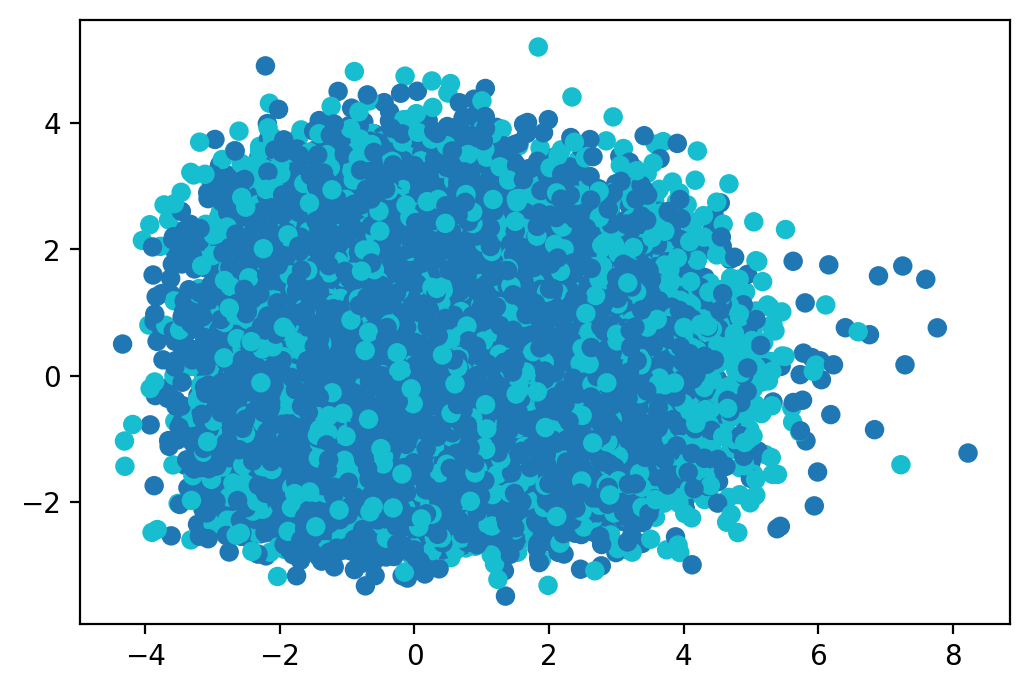

In [171]:
# Use PCA to look at the how the VAE encodes the training data in 2D.
# We look at the first to components below. 
pca = PCA(n_components=2) # Reduce dimension to 2. 

with torch.no_grad():
        for i, (x, y) in enumerate(train_data_loader): # Go through all batches of training data. 
            z = autoencoder.encoder(x.to(device))
            z = z.cpu().numpy()
            comps = pca.fit_transform(z)
            plt.scatter(comps[:, 0], comps[:, 1], c=y, cmap='tab10')
        plt.show() # Does not look good!

## This VAE obviously sucks and is nothing in comparison to the one in my project!

We need to fix it somehow, since I want it to work! Then I want to try to see what it does with two outputs, one for categorical and one for numerical. 

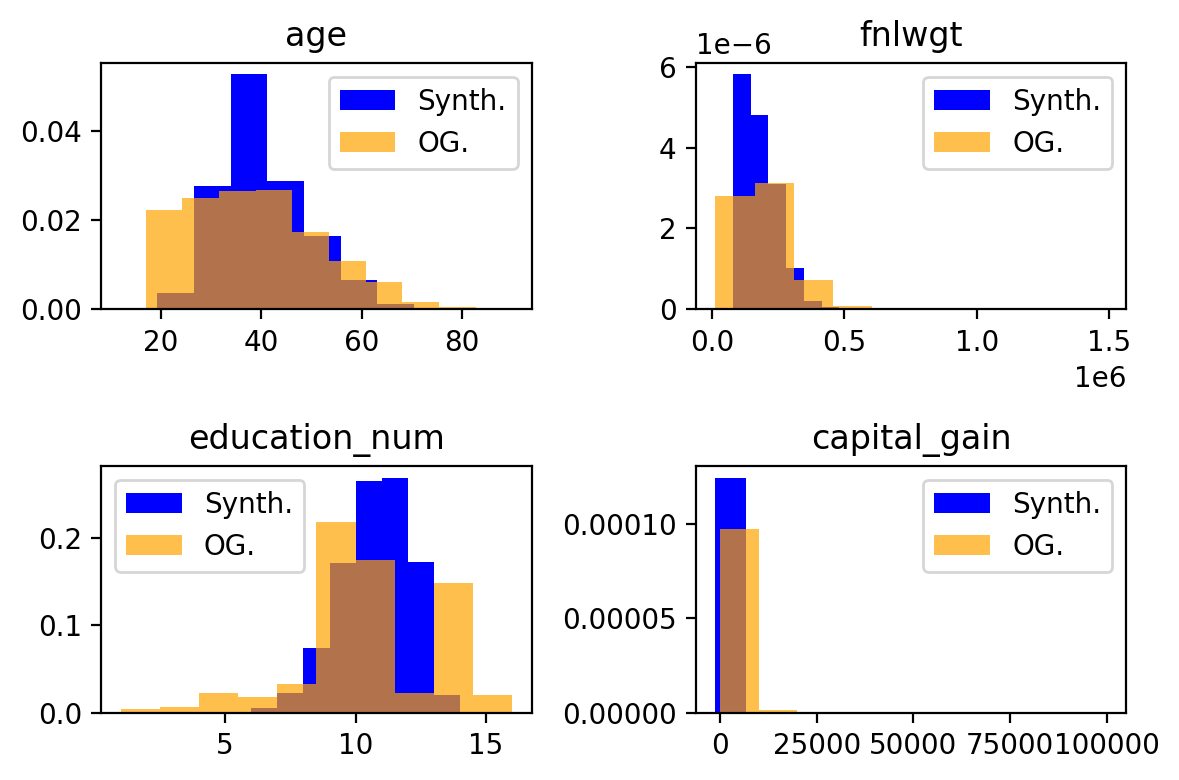

In [172]:
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for idx, ax in enumerate(axs):
    ax.hist(s_df_new[numerical_features[idx]], density = True, color = "b", label = "Synth.")
    ax.hist(adult_data[numerical_features[idx]], color = "orange", alpha = 0.7, density = True, label = "OG.")
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

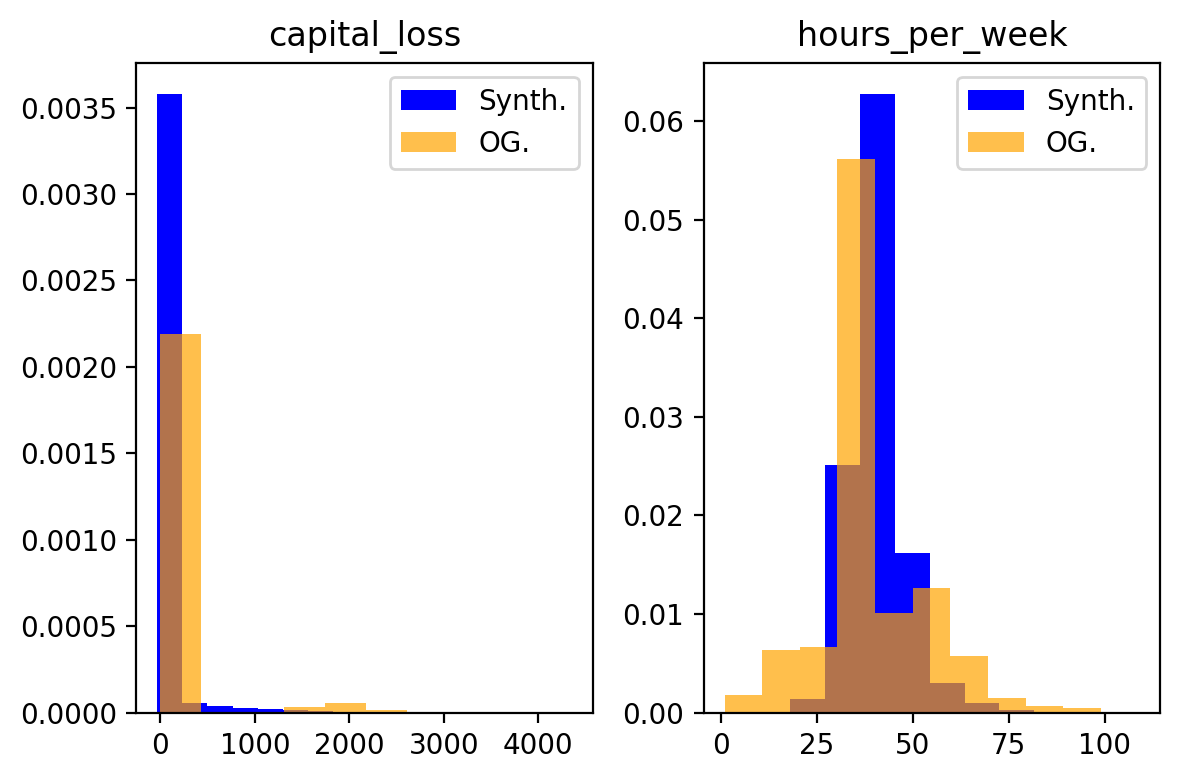

In [173]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    ax.hist(s_df_new[numerical_features[idx]], density = True, color = "b", label = "Synth.")
    ax.hist(adult_data[numerical_features[idx]], color = "orange", alpha = 0.7, density = True, label = "OG.")
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

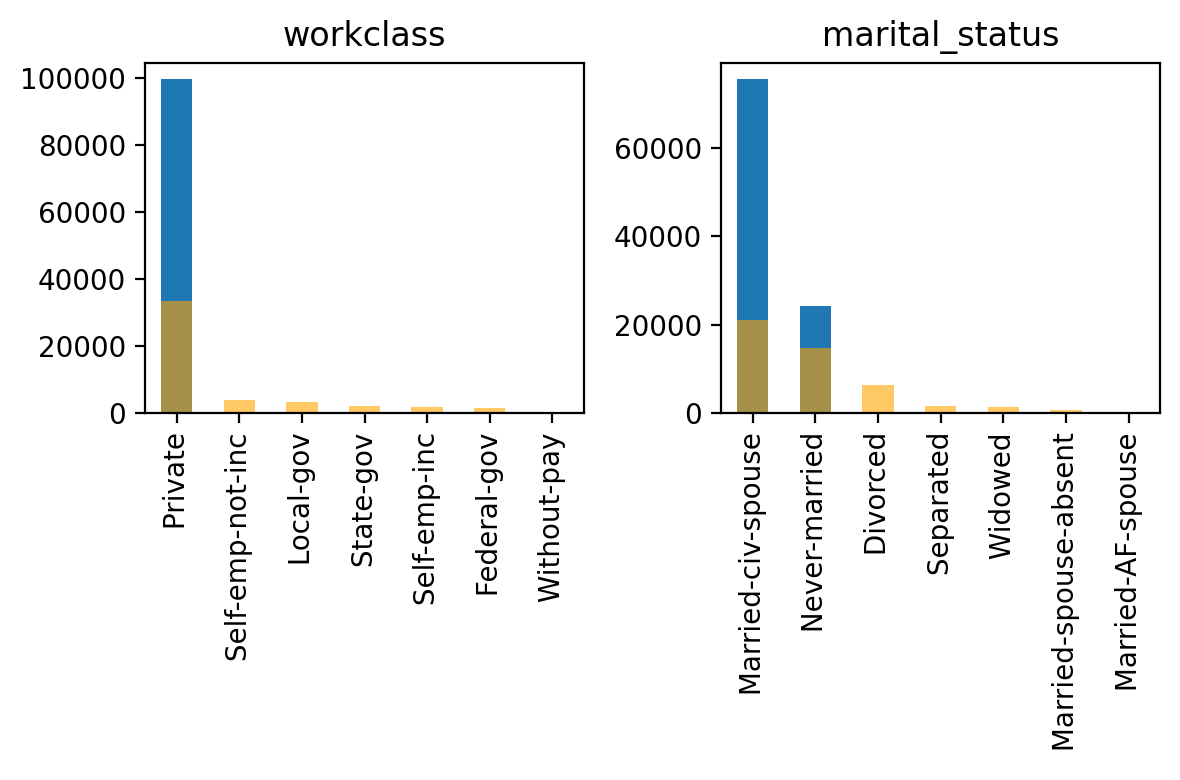

In [174]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

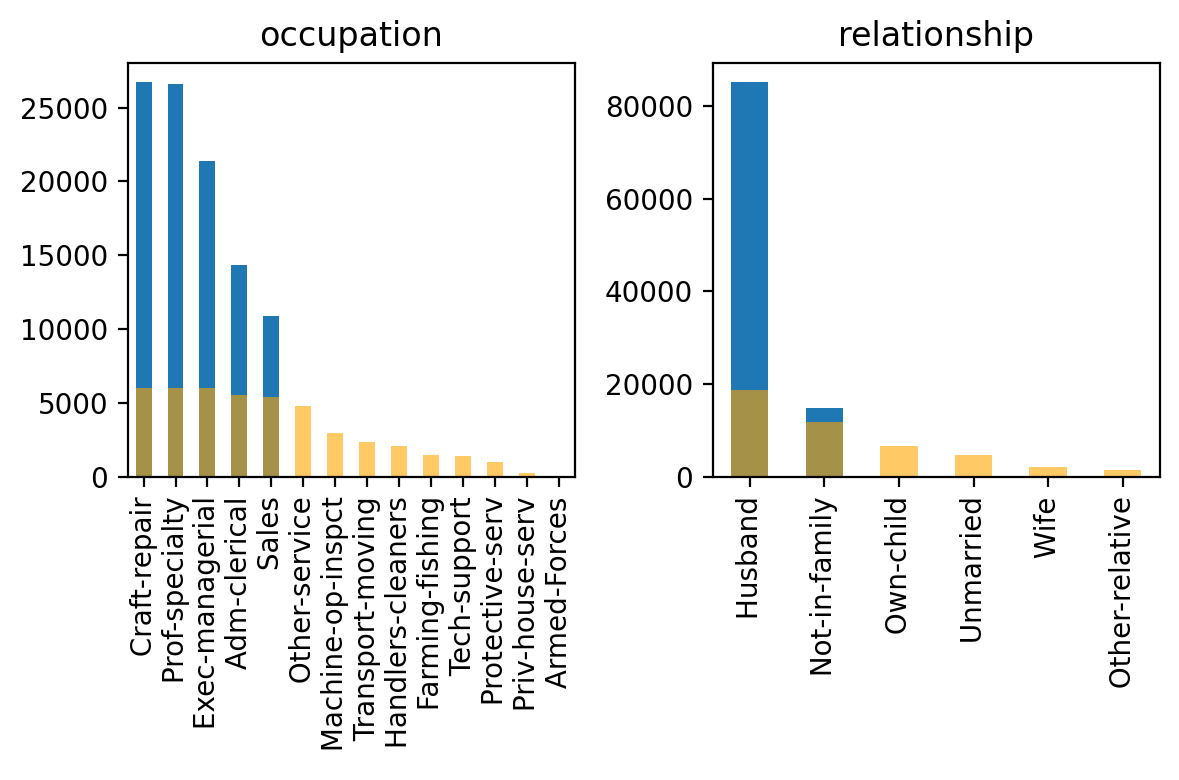

In [175]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 2):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

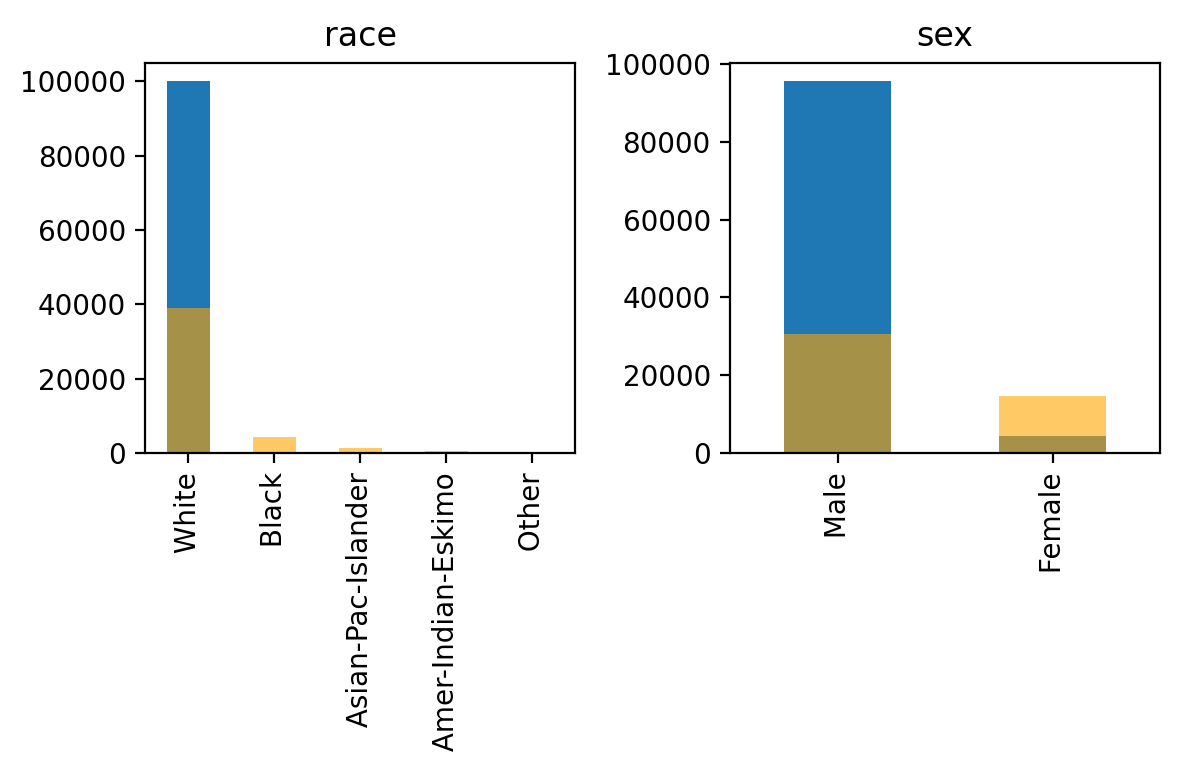

In [176]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

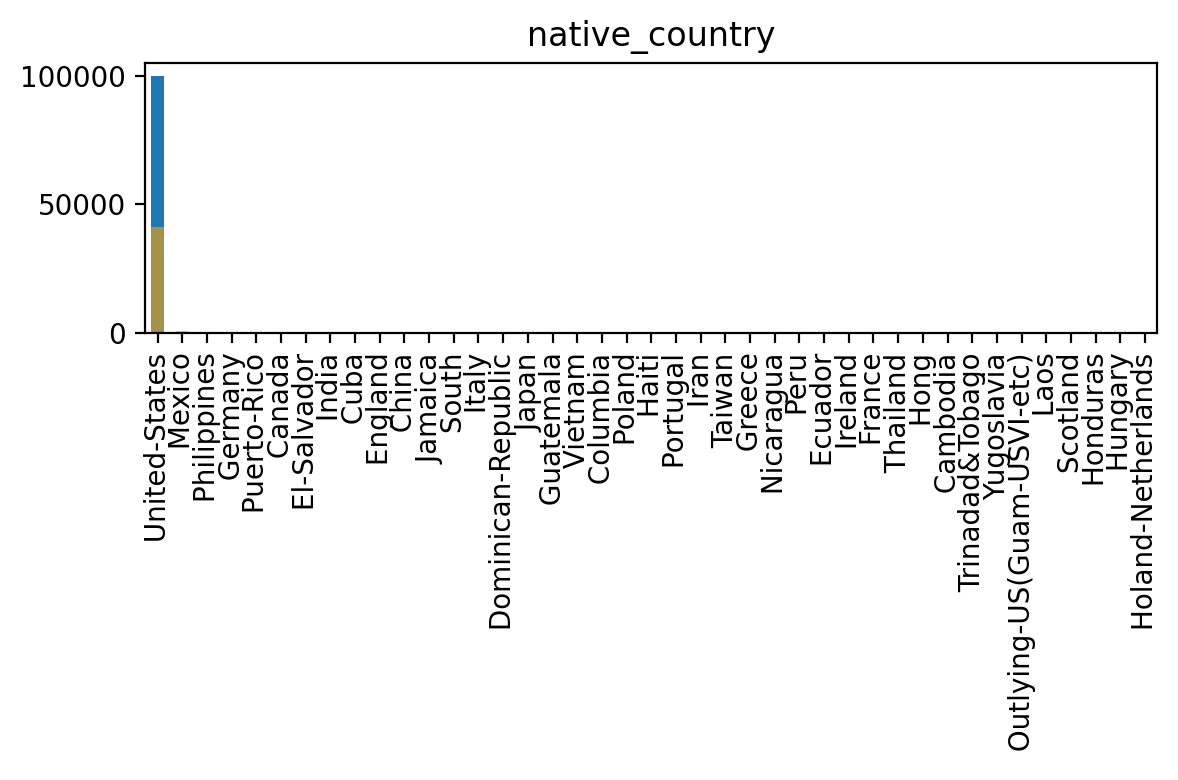

In [177]:
fig, axs = plt.subplots(1,1)
s_df_new[categorical_features[6]].value_counts().plot(kind='bar', ax = axs)
adult_data[categorical_features[6]].value_counts().plot(kind='bar', ax = axs, color = "orange", alpha = 0.6)
axs.title.set_text(categorical_features[6])
plt.tight_layout()